In [1]:
# load err analysis data

import torch
from torch.utils.data import Dataset
from PIL import Image
import pandas as pd
import os
import json


class ErrorAnalysisDataset(Dataset):
    def __init__(self, dataset_root, pred_split, img_root_dir=None, transform=None):

        self.data = pd.read_csv(os.path.join(dataset_root, "dataset.csv"))
        self.img_root_dir = img_root_dir
        self.transform = transform
        
        with open(os.path.join(dataset_root, 'mapping.json'), 'r') as f:
            self.mapping = json.load(f)
            idx_to_mapping = list(self.mapping)
            
        predictions = pd.read_csv(os.path.join(dataset_root, f"pred_splits/{pred_split}"), header=None, names=['pred'])
        self.data['pred']=predictions['pred'].values
        self.data['pred']=self.data['pred'].apply(lambda pred: self.mapping[idx_to_mapping[pred]])
        self.data['gt']=self.data['gt'].apply(lambda pred: self.mapping[idx_to_mapping[pred]])

        
    def __len__(self):
        return len(self.data)
        
    def load_image(self, img_path):
        img_path = os.path.join(self.img_root_dir, img_path)
        image = Image.open(img_path).convert('RGB')  # Ensure RGB
        
        # Apply transformations if specified
        if self.transform:
            image = self.transform(image)

        return image
        
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # Load image
        img_path = os.path.join(self.img_root_dir, self.data.iloc[idx]['img_id'])
        image = Image.open(img_path).convert('RGB')  # Ensure RGB
        
        # Apply transformations if specified
        if self.transform:
            image = self.transform(image)
        
        # Extract metadata
        attribute = self.data.iloc[idx]['attribute']
        gt_code = self.data.iloc[idx]['gt_code']
        gt = self.data.iloc[idx]['gt']
        pred = self.data.iloc[idx]['pred']

        # Return a dictionary with the image and metadata
        sample = {
            'image': image,
            # 'attribute': attribute,
            # 'gt_code': gt_code,
            # 'gt': gt,
            # 'pred': pred
        }

        return sample


In [2]:
# create a Context class that you can add to and read from, should be LLM ready

In [3]:
# confusion matrix analysis module
import numpy as np
class InitialAnalysis:
    def __init__(self, df, prediction_col, ground_truth_col, k=5):
        # Get unique classes
        classes = sorted(df[ground_truth_col].unique())
        
        # Initialize confusion matrix
        confusion_matrix = pd.DataFrame(
            np.zeros((len(classes), len(classes)), dtype=int),
            index=classes,
            columns=classes
        )
        
        # Populate the confusion matrix
        for _, row in df.iterrows():
            actual = row[ground_truth_col]
            predicted = row[prediction_col]
            confusion_matrix.loc[actual, predicted] += 1
        
        # Extract non-diagonal elements
        errors = []
        for actual in classes:
            for predicted in classes:
                if actual != predicted and confusion_matrix.loc[actual, predicted] > 0:
                    errors.append(((actual, predicted), confusion_matrix.loc[actual, predicted]))

        # Sort errors by count and take top k
        top_k_errors = sorted(errors, key=lambda x: x[1], reverse=True)[:k]

        self.confusion_matrix = confusion_matrix
        self.top_k_errors_pred_conditional = top_k_errors
        self.k = k
        self.classes = classes
        
    def human_readable_topk_pred_conditional_errors(self):
        errors_nl = []
        for (actual, predicted), err_count in self.top_k_errors_pred_conditional:
            errors_nl.append(f"The actual class is '{actual}', however model incorrectly predicts '{predicted}' {err_count} times")
            
        return '\n '.join(errors_nl)
    
    def human_readable_topk_errors_gt(self):
        marginal_errs = []
        for gt in self.classes:
            marginal_errs.append((gt, (self.confusion_matrix.loc[gt].sum()-self.confusion_matrix.loc[gt, gt]).item()))

        # select top k
        marginal_errs = sorted(marginal_errs, key=lambda x: x[1], reverse=True)[:self.k]
        
        return f"The top five marginal errors are for these classes: {marginal_errs}"


In [4]:
# test it out
dataset = ErrorAnalysisDataset(dataset_root='../mock_data_creation/mock_data', pred_split='split_0.txt', img_root_dir='/ix/akovashka/arr159/imagenet-r')
dataset.data.head()

,Unnamed: 0,img_id,attribute,gt_code,gt,pred
0,0,n01443537/art_0.jpg,art,n01443537,goldfish,missile
1,1,n01443537/art_1.jpg,art,n01443537,goldfish,goldfish
2,2,n01443537/art_10.jpg,art,n01443537,goldfish,soccer_ball
3,3,n01443537/art_11.jpg,art,n01443537,goldfish,goldfish
4,4,n01443537/art_12.jpg,art,n01443537,goldfish,goldfish


In [5]:
analysis = InitialAnalysis(dataset.data, prediction_col='pred', ground_truth_col='gt')
analysis.human_readable_topk_errors_gt()

"The top five marginal errors are for these classes: [('mushroom', 125), ('toucan', 97), ('flamingo', 96), ('bee', 81), ('jellyfish', 80)]"

In [6]:
analysis.human_readable_topk_pred_conditional_errors()

"The actual class is 'ant', however model incorrectly predicts 'burrito' 4 times\n The actual class is 'hotdog', however model incorrectly predicts 'west_highland_white_terrier' 4 times\n The actual class is 'mushroom', however model incorrectly predicts 'pig' 4 times\n The actual class is 'tank', however model incorrectly predicts 'parachute' 4 times\n The actual class is 'African_chameleon', however model incorrectly predicts 'shih_tzu' 3 times"

In [7]:
def sample(data, slice_condition, prediction_col='pred', ground_truth_col='gt', n=10):
    # filter data based on slice condition
    filtered_data = data[data.apply(slice_condition, axis=1)]
    
    # divide into error set and non error set
    error_set = filtered_data[filtered_data[prediction_col] != filtered_data[ground_truth_col]]
    non_error_set = filtered_data[filtered_data[prediction_col] == filtered_data[ground_truth_col]]

    # sample n from both sets
    sampled_error = error_set.sample(n=min(len(error_set), n), random_state=42)  # Use random_state for reproducibility
    sampled_non_error = non_error_set.sample(n=min(len(non_error_set), n), random_state=42)

    return sampled_error['img_id'].values, sampled_non_error['img_id'].values

In [8]:
sample(dataset.data, lambda x: True)

(array(['n04086273/art_3.jpg', 'n02108915/misc_42.jpg',
        'n01882714/toy_15.jpg', 'n07697537/misc_118.jpg',
        'n02356798/cartoon_11.jpg', 'n02094433/misc_37.jpg',
        'n07873807/misc_6.jpg', 'n02480855/tattoo_28.jpg',
        'n02007558/embroidery_5.jpg', 'n10565667/sketch_3.jpg'],
       dtype=object),
 array(['n03649909/misc_0.jpg', 'n01498041/misc_1.jpg',
        'n07768694/toy_0.jpg', 'n02134084/misc_119.jpg',
        'n01518878/origami_7.jpg', 'n01833805/misc_4.jpg',
        'n02802426/tattoo_6.jpg', 'n02769748/cartoon_4.jpg',
        'n01632777/sketch_17.jpg', 'n01843383/embroidery_1.jpg'],
       dtype=object))

In [9]:
# load mllm model
MAX_LENGTH = 384
MODEL_ID = "llava-hf/llava-1.5-7b-hf"

from transformers import AutoProcessor, LlavaForConditionalGeneration
import torch
processor = AutoProcessor.from_pretrained(MODEL_ID)
processor.tokenizer.padding_side = "right" # during training, one always uses padding on the right

model = LlavaForConditionalGeneration.from_pretrained(
        MODEL_ID,
        torch_dtype=torch.float16,
        # _attn_implementation="flash_attention_2",
).cuda()

Some kwargs in processor config are unused and will not have any effect: num_additional_image_tokens. 


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [10]:
# captioning, prompt for caption Caption the image with the most salient details

def caption_sets(model, processor, dataset, err_list, non_error_list, prompt="Caption the image with the most salient details"):
    images = []
    texts=[]
    images.extend([dataset.load_image(img_path) for img_path in err_list])
    images.extend([dataset.load_image(img_path) for img_path in non_error_list])

    for img in images:
        prompt = f"USER: <image>\nCaption the image with the most salient details.\nASSISTANT:"
        texts.append(prompt)

    batch = processor(text=texts, images=images, return_tensors="pt", padding=True)
    
    input_ids = batch["input_ids"].cuda()
    attention_mask = batch["attention_mask"].cuda()
    pixel_values = batch["pixel_values"].cuda()
    
    generated_ids = model.generate(input_ids=input_ids, attention_mask=attention_mask,
                                           pixel_values=pixel_values, max_new_tokens=MAX_LENGTH)
    
    predictions = processor.batch_decode(generated_ids[:, input_ids.size(1):], skip_special_tokens=True)
    
    err_list_prompt = [f'A sample with a incorrect prediction has description: ' for i, _ in enumerate(err_list)]
    non_err_list_prompt = [f'A sample with a correct prediction has description: ' for i, _ in enumerate(non_error_list)]
    return [f'{text}{predictions[i]}' for i, text in enumerate([*err_list_prompt, *non_err_list_prompt])]


In [11]:
# testing
err_list, non_err_list = sample(dataset.data, lambda x: True)

caption_sets(model, processor, dataset, err_list, non_err_list)

Expanding inputs for image tokens in LLaVa should be done in processing. Please add `patch_size` and `vision_feature_select_strategy` to the model's processing config or set directly with `processor.patch_size = {{patch_size}}` and processor.vision_feature_select_strategy = {{vision_feature_select_strategy}}`. Using processors without these attributes in the config is deprecated and will throw an error in v4.47.


["A sample with a incorrect prediction has description: The image features a woman wearing a yellow shirt with a gun design on it. The shirt has a green and red color scheme, and the gun is prominently displayed on the front. The woman appears to be the main focus of the image, and the shirt's design adds a unique touch to her outfit.",
 "A sample with a incorrect prediction has description: The image is a black and white drawing of a small dog with a bow tie. The dog is looking directly at the viewer, capturing attention. The drawing is quite detailed, showcasing the dog's facial features and the bow tie it is wearing. The overall composition of the drawing is visually appealing and captures the essence of the dog's personality.",
 'A sample with a incorrect prediction has description: The image features a stuffed koala bear sitting on a wooden table. The koala is wearing a white shirt and has a brown and white color scheme. The bear is positioned in the center of the scene, occupying

In [12]:
# load LLM
import os

# Set the master address and port
os.environ['MASTER_ADDR'] = '127.0.0.1'
os.environ['MASTER_PORT'] = '29500'
os.environ["RANK"] = "0"
os.environ["WORLD_SIZE"] = "1"
from llama_models.llama3.reference_impl.generation import Llama
from llama_models.llama3.api.datatypes import (
    CompletionMessage,
    StopReason,
    SystemMessage,
    UserMessage,
)

temperature = 0.6
top_p = 0.9
max_seq_len = 10000
max_batch_size = 4
max_gen_len = None
model_parallel_size = None
tokenizer_path = str("/ix/cs3550_2024f/ErrAttr-ID/tokenizer.model")
generator = Llama.build(
    ckpt_dir="/ix/cs3550_2024f/ErrAttr-ID/Llama3.1-8B-Instruct",
    tokenizer_path=tokenizer_path,
    max_seq_len=max_seq_len,
    max_batch_size=max_batch_size,
    model_parallel_size=model_parallel_size,
)


[W1207 18:56:47.648702329 socket.cpp:697] [c10d] The client socket cannot be initialized to connect to [localhost]:29500 (errno: 97 - Address family not supported by protocol).


> initializing model parallel with size 1
> initializing ddp with size 1
> initializing pipeline with size 1


/ihome/akovashka/arr159/miniconda3/envs/sports_feedback2/lib/python3.10/site-packages/torch/__init__.py:955: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /opt/conda/conda-bld/pytorch_1724789115564/work/torch/csrc/tensor/python_tensor.cpp:432.)
  _C._set_default_tensor_type(t)


Loaded in 5.50 seconds


In [41]:
# hypothesis + validator class

"""
Hypothesis Formulation:
Uses a LLM to formulate (1) a hypothesis on what might be a possible error-prone 
attribute given the context and (2) a labeling prompt given the generated hypothesis 
(e.g. given hypothesis "The model is likely misclassifying images in poorly lit 
conditions because details of the object are obscured.", the labeling prompt would be 
"For each image, label whether the lighting condition is: [1] 'Bright', [2] 'Dim', 
or [3] 'Dark'.")

Validation:
Using an M-LLM, the images in each set are labeled using the labeling prompt from the 
hypothesis formulation step (constrains the labeling space), and then error-rates are 
re-computed for each attribute in the labeled subset (e.g. given the hypothesis/prompt 
example above, the results could be Bright: 0.75 ER, Dim: 0.2 ER, Dark: 0.25 ER; note 
this doesn’t need to sum to 1) and this result is passed to the context.
"""

class ExperimentFlow:
    def __init__(self, llm, mllm=None, verbose=False):
        self.llm = llm
        self.mllm = mllm
        self.verbose = verbose

    def form_hypothesis(self, context, 
                        prompt='''Formulate a hypothesis on why the misclassified images might be failing.'''):
        
        dialog = [
                SystemMessage(content=prompt),
                UserMessage(content=f'''Context: "The actual class is 'ant', however model incorrectly predicts 'burrito' 4 times\n The actual class is 'hotdog', however model incorrectly predicts 'west_highland_white_terrier' 4 times\n The actual class is 'mushroom', however model incorrectly predicts 'pig' 4 times\n The actual class is 'tank', however model incorrectly predicts 'parachute' 4 times\n The actual class is 'African_chameleon', however model incorrectly predicts 'shih_tzu' 3 times" Description: "A sample with an incorrect prediction has description: The image features a woman wearing a yellow shirt with a gun design on it. The shirt has a green and red color scheme, and the gun is prominently displayed on the front. The image is taken in a dimly lit room, making the colors appear muted and details of the gun design less distinct."
                    "A sample with an incorrect prediction has description: The image is a black and white drawing of a small dog with a bow tie. The drawing was photographed under low light, causing shadows to obscure some details of the bow tie."
                    "A sample with a correct prediction has description: The image features a cartoon-like drawing of a lizard with a sad expression. Despite being in low light, the high contrast in the drawing ensures that the lizard's details remain visible."
                    "A sample with a correct prediction has description: The image features a colorful, hand-woven blanket with a bird design. The bright and vibrant colors make the details of the bird clear, even under dim lighting." \nHypothesis:'''),
                CompletionMessage(
                    content="""The model is likely misclassifying images in poorly lit conditions because details of the object are obscured.""",
                    stop_reason=StopReason.end_of_turn,
                ),
                UserMessage(content=f'\nContext: {context}\nHypothesis: '),
            ]
        result = self.llm.chat_completion(
            dialog,
            max_gen_len=max_gen_len,
            temperature=temperature,
            top_p=top_p,
        )
        if self.verbose:
            for msg in dialog:
                print(f"{msg.role.capitalize()}: {msg.content}\n")
    
        return result.generation.content

    def get_labeling_prompt(self, hypothesis, prompt="Create a extremely concise labeling prompt given a hypothesis"):
        dialog = [
                SystemMessage(content=prompt),
                UserMessage(content=f'Hypothesis: The model is likely misclassifying images in poorly lit conditions because details of the object are obscured.\nLabeling Prompt: '),
                CompletionMessage(
                    content="""For each image, label from two options whether the lighting condition is: [1] 'Bright', [2] 'Dim/Dark'.""",
                    stop_reason=StopReason.end_of_turn,
                ),
                UserMessage(content=f'Hypothesis: {hypothesis}\nLabeling Prompt: ')
        ]

        result = self.llm.chat_completion(
            dialog,
            max_gen_len=max_gen_len,
            temperature=temperature,
            top_p=top_p,
        )
        
        if self.verbose:
            for msg in dialog:
                print(f"{msg.role.capitalize()}: {msg.content}\n")
    
        return result.generation.content
    def label_images(self, image_list, labeling_prompt):
        images = [dataset.load_image(img_path) for img_path in image_list]
        # texts=[]
        predictions = []
        # self.mllm['model'].eval()

        # batch size 1 due to GPU mem limit with LLM
        for img in images:
            prompt = f"USER: <image>\n {labeling_prompt}\nASSISTANT:"
            # texts.append(prompt)
    
            batch = self.mllm['processor'](text=[prompt], images=[img], return_tensors="pt", padding=True)
            
            input_ids = batch["input_ids"].cuda()
            attention_mask = batch["attention_mask"].cuda()
            pixel_values = batch["pixel_values"].cuda()
        
            generated_ids = self.mllm['model'].generate(input_ids=input_ids, attention_mask=attention_mask,
                                                   pixel_values=pixel_values, max_new_tokens=100)
            
            pred = self.mllm['processor'].batch_decode(generated_ids[:, input_ids.size(1):], skip_special_tokens=True)
            predictions.append(pred[0])
        return predictions
    
    def validate(self, labeling_prompt, error_img_list, correct_img_list):
        def iou(prediction, ground_truth):
            tokenized_prediction = set(prediction.split())
            tokenized_ground_truth =  set(ground_truth.split())
            return len(tokenized_prediction.intersection(tokenized_ground_truth))/len(tokenized_ground_truth)
        def parse_categories(labeling_prompt):
            # Extract categories from the prompt
            categories = []
            lines = labeling_prompt.split("\n")
            for line in lines:
                if "[" in line and "]" in line:
                    # Extract text between [number] and the label
                    category = line.split("]")[1].strip(" '")
                    if ":" in line:
                        category=category.split(":")[0]
                    categories.append(category)
            return categories
            
        def get_match(prediction, categories):
            for category in categories:
                if iou(prediction.lower(), category.lower()) > 0.2:
                    return category
            return "Unknown"
            
        def calc_err_rate(attribute_classifications, err_list, categories):
            # 1 represents error in err_list
            category_errors = {category: 0 for category in categories}
            total_count = {category: 0 for category in categories}
        
            # Calculate errors and counts for each category
            for i, classification in enumerate(attribute_classifications):
                if classification in categories:
                    total_count[classification] += 1
                    if i < len(err_list)//2:  # Error list indices
                        category_errors[classification] += 1
            
            # Calculate error rate per category
            error_rates = {
                category: (category_errors[category] / total_count[category]) if total_count[category] > 0 else 0
                for category in categories
            }
            return error_rates
            
        categories = parse_categories(labeling_prompt)
        categories.append("Unknown")
        print(categories)
        predictions = self.label_images([*error_img_list, *correct_img_list], labeling_prompt)
        print("predictions")
        print(predictions)
        attribute_classifications=[]
        for i, _ in enumerate(error_img_list):
            attribute_classifications.append(get_match(predictions[i], categories))
        for i, _ in enumerate(correct_img_list):
            attribute_classifications.append(get_match(predictions[i+len(error_img_list)], categories))

        print("attribute classifications")
        print(attribute_classifications)
        
        error_rates = calc_err_rate(attribute_classifications, [1 if i < len(error_img_list) else 0 for i in range(len(error_img_list)+len(correct_img_list))], categories)

        # todo: validate hypothesis based on err_rates calculated, maybe leave for later?
        return error_rates


In [42]:
# test
experiment = ExperimentFlow(generator, mllm={'processor': processor, 'model':model})

In [27]:
# hypothesis test -> for artistic rendition
test_context = '''
"The top five marginal errors are for these classes: [('dog', 125), ('apple', 97), ('flamingo', 96), ('bee', 81), ('jellyfish', 80)]"
Description:
"A sample with an incorrect prediction has description: The image is a cartoon-style drawing of a dog with long, exaggerated ears and a pointed snout. The dog is depicted with flat colors and no fur details, resembling a fox's silhouette.
A sample with an incorrect prediction has description: The image is an abstract painting of an apple, with its round shape emphasized and no clear stem or leaf visible, making it appear similar to a ball.
A sample with a correct prediction has description: The image is a realistic photograph of a car taken in bright lighting, with clear details like the brand logo, tires, and windows visible.
A sample with a correct prediction has description: The image is a high-resolution photograph of a tree in a park, with sharp details in the bark, leaves, and branches, making it distinct from abstract or cartoon-like styles."
'''
test_hypothesis = experiment.form_hypothesis(test_context)
print("Output hypothesis:", test_hypothesis)
test_labeling_prompt = experiment.get_labeling_prompt(test_hypothesis)
print("Output labeling prompt:", test_labeling_prompt)

# so far so good


Output hypothesis: The model is likely misclassifying images when the object is depicted in a stylized, abstract, or simplified manner, such as:

* Cartoon-style drawings with exaggerated features (e.g. dog with long ears)
* Abstract paintings or depictions with minimal details (e.g. apple with no stem or leaves)
* Simplified or silhouetted forms (e.g. fox-like silhouette of a dog)

In contrast, the model is more accurate when the object is depicted in a realistic, high-resolution, and detailed manner (e.g. photographs of cars or trees).
Output labeling prompt: For each image, label from two options whether the object depiction style is: [1] 'Realistic', [2] 'Abstract/Stylized'.


In [28]:
class_name = 'goose'
test_labeling_prompt=f'''For each {class_name} image, label one of the following categories:
[1] **Cartoon/Abstract**: Image is cartoonish, abstract, or lacks detail. 
[2] **Realistic/High-Res**: Image is realistic, high-resolution, and detailed.
[3] **Other**: Image does not fit into the above categories.'''

# test_labeling_prompt='''For each image, label one of the following categories:
# [1] Cartoon/Abstract [2] Realistic/High-Res [3] Other'''
test_img_list = sample(dataset.data, lambda x: x['gt']=='goose')[0]


In [29]:
experiment.label_images(test_img_list, test_labeling_prompt)

['[1] **Cartoon/Abstract**',
 '[1] **Cartoon/Abstract**',
 '[2] **Realistic/High-Res**',
 '[1] **Cartoon/Abstract**',
 '[1] **Cartoon/Abstract**: The goose is depicted in a cartoonish or abstract manner, making it appear as a silhouette.',
 '[1] **Cartoon/Abstract**',
 '[2] **Realistic/High-Res**: The image is a realistic, high-resolution, and detailed painting of a goose flying over a body of water.',
 '[2] **Realistic/High-Res**',
 '[2] **Realistic/High-Res**: The image is a detailed drawing of a goose in the water.',
 '[2] **Realistic/High-Res**']

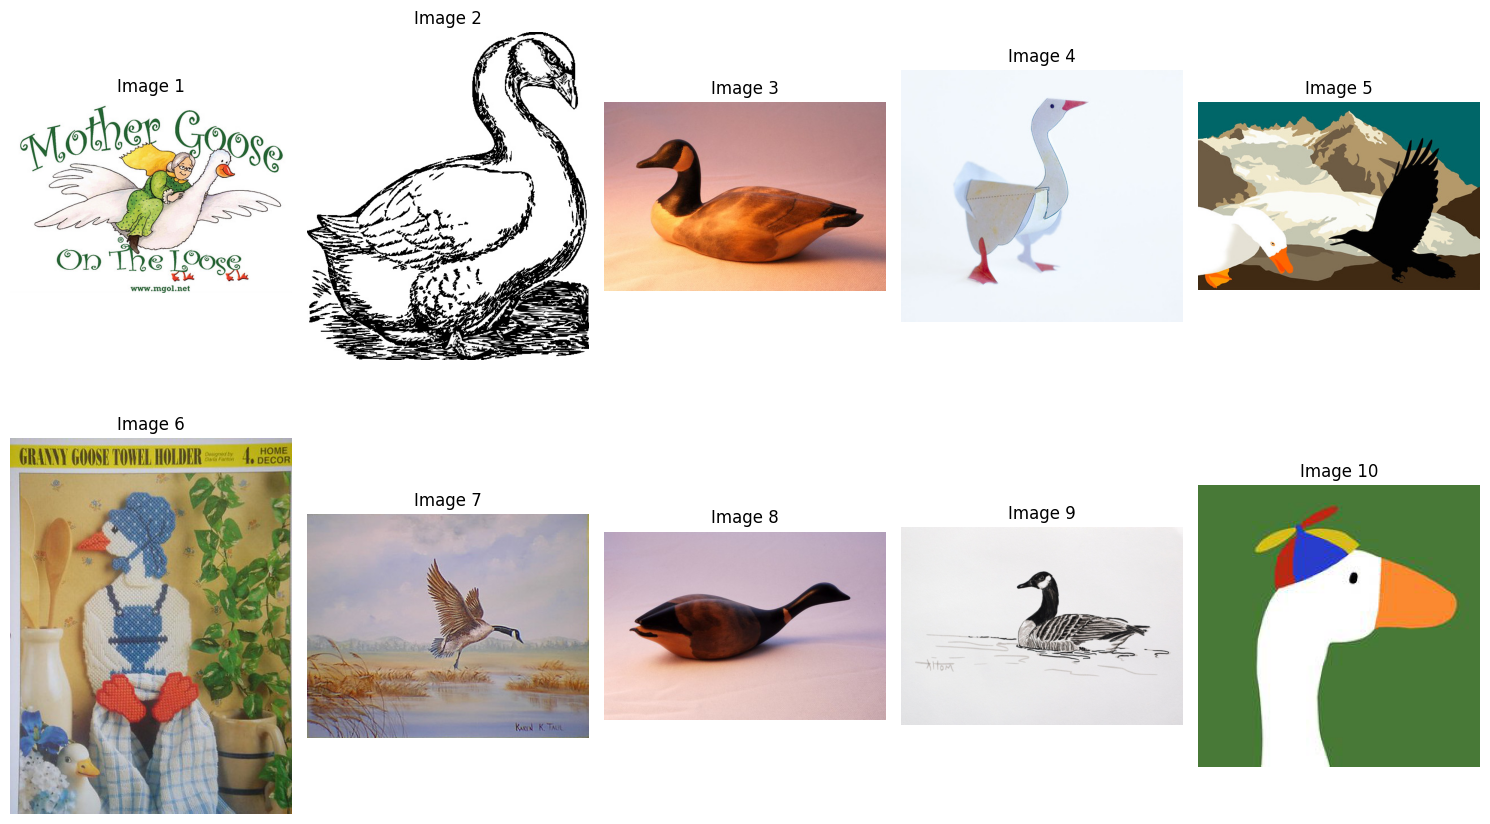

In [30]:
import matplotlib.pyplot as plt
test_images = [dataset.load_image(img) for img in test_img_list]
plt.figure(figsize=(15, 10))  # Adjust figure size as needed

for i, img in enumerate(test_images):
    plt.subplot(2, 5, i + 1)  # 2 rows, 5 columns grid
    plt.imshow(img)
    plt.axis('off')  # Turn off axes
    plt.title(f"Image {i+1}")  # Optional: Add titles

plt.tight_layout()
plt.show()

In [43]:
# testing if validate executes; not correctness
experiment.validate(test_labeling_prompt, test_img_list, test_img_list)

['**Cartoon/Abstract**', '**Realistic/High-Res**', '**Other**', 'Unknown']
predictions
['[1] **Cartoon/Abstract**', '[1] **Cartoon/Abstract**', '[2] **Realistic/High-Res**', '[1] **Cartoon/Abstract**', '[1] **Cartoon/Abstract**: The goose is depicted in a cartoonish or abstract manner, making it appear as a silhouette.', '[1] **Cartoon/Abstract**', '[2] **Realistic/High-Res**: The image is a realistic, high-resolution, and detailed painting of a goose flying over a body of water.', '[2] **Realistic/High-Res**', '[2] **Realistic/High-Res**: The image is a detailed drawing of a goose in the water.', '[2] **Realistic/High-Res**', '[1] **Cartoon/Abstract**', '[1] **Cartoon/Abstract**', '[2] **Realistic/High-Res**', '[1] **Cartoon/Abstract**', '[1] **Cartoon/Abstract**: The goose is depicted in a cartoonish or abstract manner, making it appear as a silhouette.', '[1] **Cartoon/Abstract**', '[2] **Realistic/High-Res**: The image is a realistic, high-resolution, and detailed painting of a goo

{'**Cartoon/Abstract**': 0.5,
 '**Realistic/High-Res**': 0.5,
 '**Other**': 0,
 'Unknown': 0.5}

In [ ]:
# conclusion; maybe just use LLM-brain, find prompt? max steps?

In [ ]:
# llm brain class